In [56]:
import numpy as np
from skimage import data
from skimage . color import rgb2gray
import matplotlib . pyplot as plt
from mpl_toolkits . mplot3d import Axes3D
import cv2 as cv # librairie OpenCV
from tqdm import tqdm
from numba import njit
import time

In [33]:
@njit
def block_matching(Iref, Isearch, N, maxdisp):
    disp = np.zeros_like(Iref)
    margin = N//2
    for i in np.arange(margin,Iref.shape[0] - margin):
        for j in np.arange(margin, Iref.shape[1] - margin):
            ref_block = Iref[i-margin:i+margin+1,j-margin:j+margin+1]
            min_sad=np.inf
            min_pos=0
            for x_dec in np.arange(0, maxdisp):
                new_x = j-x_dec
                if new_x >= margin:
                    search_block = Isearch[i-margin:i+margin+1, new_x-margin:new_x+margin+1]
                    sad=(np.abs(ref_block - search_block)).sum()
                    if sad < min_sad:
                        min_sad=sad
                        min_pos=x_dec
            disp[i,j]=min_pos
    return disp

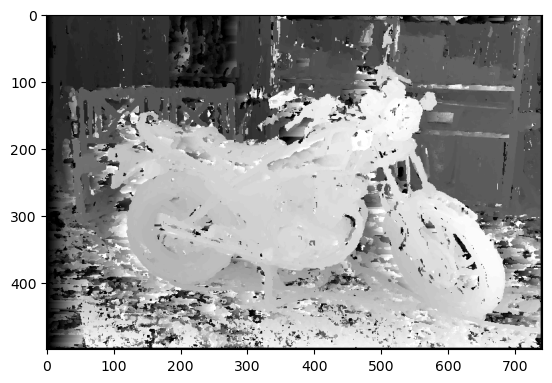

In [47]:
Ig, Id, gt = data.stereo_motorcycle()
maxdisp = 60
disp = block_matching(rgb2gray(Ig), rgb2gray(Id), 5, maxdisp)
plt.imshow(sto, cmap="gray")

In [76]:
# Measure the execution time
@njit
def mode_filter(img, N=5):
    filtered_img = np.zeros_like(img)
    pas = N//2
    for i in np.arange(pas,img.shape [0]-pas):
        for j in np.arange(pas, img.shape [1]-pas):
            block = img[i-pas:i+pas+1,j-pas:j+pas+1]
            occ = {val:0 for val in set(block.flatten())}
            for val in block.flatten():
                occ[val]+=1
                
            max_k=0
            max_val=0
            for key, value in occ.items():
                if value > max_val:
                    max_k=key
                    max_val=value
            filtered_img[i,j]=max_k
    return filtered_img


Execution time: 1.3119266033172607 seconds


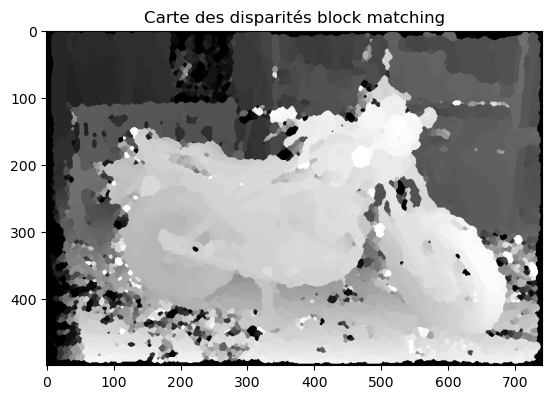

In [77]:
# test la fonction
Ig, Id, gt = data.stereo_motorcycle ()
block_size = 5
max_disp = 60
start_time = time.time()
disp = mode_filter(disp, block_size)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
plt. figure ()
plt. imshow ( disp , cmap = "gray" )
plt. title ( "Carte des disparités block matching" )
plt.show()